# EDA

In [ ]:
import os
import random
import shutil

def move_images(src_dir, dst_dir, num_images_to_move):
    # List all image files in the source directory
    image_files = [f for f in os.listdir(src_dir) if f.endswith(('.jpg', '.png'))]

    # Randomly select the images to move
    images_to_move = random.sample(image_files, num_images_to_move)

    # Move each selected image to the destination directory
    for image in images_to_move:
        src_path = os.path.join(src_dir, image)
        dst_path = os.path.join(dst_dir, image)
        shutil.move(src_path, dst_path)

# Paths to the original dataset
original_dataset_dir = '/content/drive/MyDrive/dataset'

# Directories for train, validation, and test
train_dir = os.path.join(original_dataset_dir, 'train')
validation_dir = os.path.join(original_dataset_dir, 'validation')
test_dir = os.path.join(original_dataset_dir, 'test')

os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Desired counts for validation and test sets per class
desired_validation_count = 96
desired_test_count =120

# Iterate over each class directory for redistribution from validation to train
for class_name in os.listdir(validation_dir):
    train_class_dir = os.path.join(train_dir, class_name)
    validation_class_dir = os.path.join(validation_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)

    if os.path.isdir(validation_class_dir):
        # Calculate the number of images to move back to train
        current_validation_count = len(os.listdir(validation_class_dir))
        num_images_to_move_to_train = max(0, current_validation_count - desired_validation_count)

        # Calculate the number of images to move to test
        num_images_to_move_to_test = max(0, desired_test_count - len(os.listdir(test_class_dir)))

        print(f"Adjusting class '{class_name}'...")
        move_images(validation_class_dir, train_class_dir, num_images_to_move_to_train)
        move_images(validation_class_dir, test_class_dir, num_images_to_move_to_test)

print("Data redistribution completed.")


Adjusting class 'beach'...
Adjusting class 'library'...
Adjusting class 'airport'...
Adjusting class 'restaurant'...
Adjusting class 'gym'...
Data redistribution completed.


Detailed EDA Summary:
        Class  Train Count  Validation Count  Test Count
0     airport          384                96         120
1       beach          384                96         120
2         gym          384                96         120
3     library          384                96         120
4  restaurant          384                96         120

Summary Statistics:
Total images in Training set: 1920
Total images in Validation set: 480
Total images in Testing set: 600

Class-wise distribution:
     Class  Train Count  Validation Count  Test Count
   airport          384                96         120
     beach          384                96         120
       gym          384                96         120
   library          384                96         120
restaurant          384                96         120


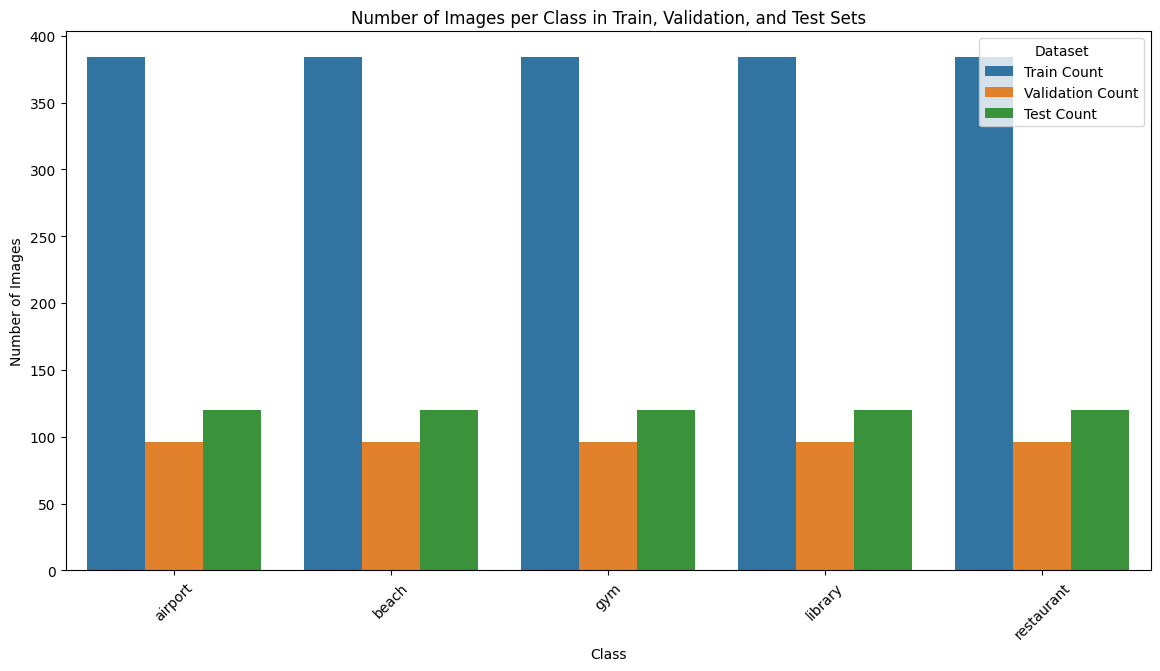

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def count_images_in_dir(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            image_files = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png'))]
            class_counts[class_name] = len(image_files)
    return class_counts

def detailed_eda(train_dir, val_dir, test_dir):
    train_counts = count_images_in_dir(train_dir)
    val_counts = count_images_in_dir(val_dir)
    test_counts = count_images_in_dir(test_dir)

    data = {
        'Class': [],
        'Train Count': [],
        'Validation Count': [],
        'Test Count': []
    }

    classes = sorted(set(train_counts.keys()).union(val_counts.keys()).union(test_counts.keys()))

    for class_name in classes:
        data['Class'].append(class_name)
        data['Train Count'].append(train_counts.get(class_name, 0))
        data['Validation Count'].append(val_counts.get(class_name, 0))
        data['Test Count'].append(test_counts.get(class_name, 0))

    df = pd.DataFrame(data)
    return df

def plot_eda(df):
    df_melted = df.melt(id_vars='Class', value_vars=['Train Count', 'Validation Count', 'Test Count'],
                        var_name='Dataset', value_name='Count')

    plt.figure(figsize=(14, 7))
    sns.barplot(x='Class', y='Count', hue='Dataset', data=df_melted)
    plt.title('Number of Images per Class in Train, Validation, and Test Sets')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.legend(title='Dataset')
    plt.show()

# Paths to datasets
train_dir = '/content/drive/MyDrive/dataset/train'
validation_dir = '/content/drive/MyDrive/dataset/validation'
test_dir = '/content/drive/MyDrive/dataset/test'

# Perform EDA
eda_df = detailed_eda(train_dir, validation_dir, test_dir)

# Print the detailed EDA
print("Detailed EDA Summary:")
print(eda_df)

# Summary statistics
print("\nSummary Statistics:")
print("Total images in Training set:", eda_df['Train Count'].sum())
print("Total images in Validation set:", eda_df['Validation Count'].sum())
print("Total images in Testing set:", eda_df['Test Count'].sum())
print("\nClass-wise distribution:")
print(eda_df.to_string(index=False))

# Plot the EDA results
plot_eda(eda_df)


# Data pre-processing: Resizing, Normalistion, Flattening, Encoding

In [2]:
import os
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Set the image dimensions
IMG_HEIGHT = 64
IMG_WIDTH = 64

# Function to load images and extract features
def load_images_from_folder(folder, img_height, img_width):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                img_path = os.path.join(label_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (img_height, img_width))
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

# Load train, validation, and test sets
train_folder = '/content/drive/MyDrive/dataset/train'
val_folder = '/content/drive/MyDrive/dataset/validation'
test_folder = '/content/drive/MyDrive/dataset/test'

X_train, y_train = load_images_from_folder(train_folder, IMG_HEIGHT, IMG_WIDTH)
X_val, y_val = load_images_from_folder(val_folder, IMG_HEIGHT, IMG_WIDTH)
X_test, y_test = load_images_from_folder(test_folder, IMG_HEIGHT, IMG_WIDTH)


In [3]:
# Normalize images
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Flatten images
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_val_flat = X_val.reshape((X_val.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)


##Supervised Learning with decision tree

In [ ]:
# Initialize and train the Decision Tree classifier
clf = DecisionTreeClassifier()
clf.fit(X_train_flat, y_train_enc)

# Validate the classifier
y_val_pred = clf.predict(X_val_flat)
print(f'Validation Accuracy: {accuracy_score(y_val_enc, y_val_pred)}')
print(f'Validation Classification Report:\n{classification_report(y_val_enc, y_val_pred, target_names=le.classes_)}')


Validation Accuracy: 0.53125
Validation Classification Report:
              precision    recall  f1-score   support

     airport       0.49      0.51      0.50        96
       beach       0.83      0.72      0.77        96
         gym       0.64      0.76      0.70        96
     library       0.28      0.29      0.29        96
  restaurant       0.42      0.38      0.40        96

    accuracy                           0.53       480
   macro avg       0.53      0.53      0.53       480
weighted avg       0.53      0.53      0.53       480




Test Performance Metrics
Test Accuracy: 0.5616666666666666
Test Precision: 0.5543402072120607
Test Recall: 0.5616666666666666
Test F1 Score: 0.5552854435029495
Test Classification Report:
              precision    recall  f1-score   support

     airport       0.51      0.57      0.54       120
       beach       0.78      0.75      0.77       120
         gym       0.65      0.78      0.71       120
     library       0.38      0.35      0.36       120
  restaurant       0.45      0.36      0.40       120

    accuracy                           0.56       600
   macro avg       0.55      0.56      0.56       600
weighted avg       0.55      0.56      0.56       600



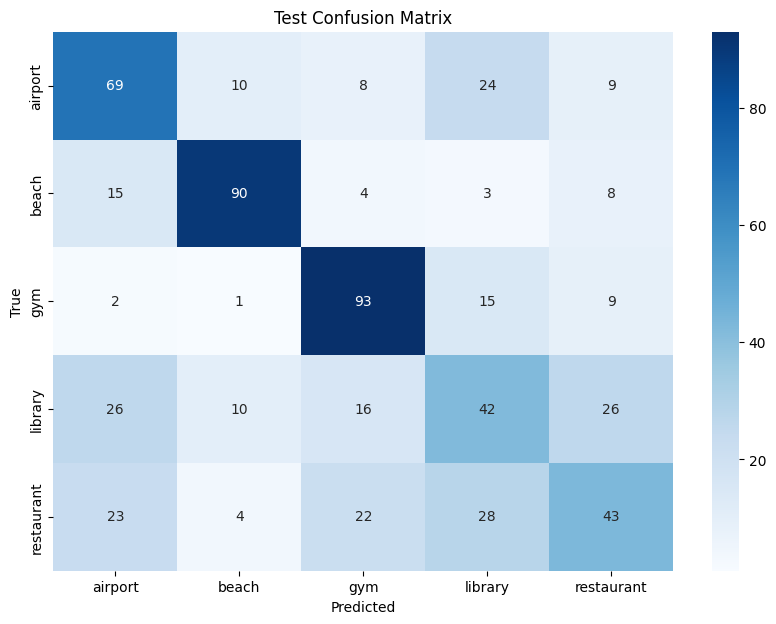

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix# Evaluate the classifier on the test set
y_test_pred = clf.predict(X_test_flat)
test_accuracy = accuracy_score(y_test_enc, y_test_pred)
test_precision = precision_score(y_test_enc, y_test_pred, average='weighted')
test_recall = recall_score(y_test_enc, y_test_pred, average='weighted')
test_f1 = f1_score(y_test_enc, y_test_pred, average='weighted')
test_conf_matrix = confusion_matrix(y_test_enc, y_test_pred)

print("\nTest Performance Metrics")
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test F1 Score: {test_f1}')
print(f'Test Classification Report:\n{classification_report(y_test_enc, y_test_pred, target_names=le.classes_)}')

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()


##Semi supervised learning Classification with Decision Trees

In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Split the training data into labelled (20%) and unlabeled (80%)
X_train_labeled, X_train_unlabeled, y_train_labeled, y_train_unlabeled = train_test_split(X_train_flat, y_train_enc, test_size=0.8, stratify=y_train_enc, random_state=42)

# Function to perform semi-supervised learning
def semi_supervised_learning(X_labeled, y_labeled, X_unlabeled, iterations=5, confidence_threshold=0.85):
    clf = DecisionTreeClassifier()
    for iteration in range(iterations):
        clf.fit(X_labeled, y_labeled)
        y_unlabeled_pred = clf.predict_proba(X_unlabeled)
        high_confidence_idx = np.where((np.max(y_unlabeled_pred, axis=1) >= confidence_threshold))[0]

        # Check if there are high-confidence samples
        if len(high_confidence_idx) == 0:
            print(f"No high-confidence samples found in iteration {iteration}. Stopping early.")
            break

        X_high_conf = X_unlabeled[high_confidence_idx]
        y_high_conf = np.argmax(y_unlabeled_pred[high_confidence_idx], axis=1)

        X_labeled = np.vstack((X_labeled, X_high_conf))
        y_labeled = np.hstack((y_labeled, y_high_conf))

        # Remove high-confidence samples from the unlabeled set
        X_unlabeled = np.delete(X_unlabeled, high_confidence_idx, axis=0)

        # If no more unlabeled samples, break
        if X_unlabeled.shape[0] == 0:
            print("No more unlabeled samples remaining. Stopping early.")
            break

    return clf

# Perform semi-supervised learning
clf_semi_supervised = semi_supervised_learning(X_train_labeled, y_train_labeled, X_train_unlabeled)

# Evaluate the classifier on the test set
y_test_pred = clf_semi_supervised.predict(X_test_flat)
test_accuracy = accuracy_score(y_test_enc, y_test_pred)
test_precision = precision_score(y_test_enc, y_test_pred, average='weighted')
test_recall = recall_score(y_test_enc, y_test_pred, average='weighted')
test_f1 = f1_score(y_test_enc, y_test_pred, average='weighted')
test_conf_matrix = confusion_matrix(y_test_enc, y_test_pred)

print("\nTest Performance Metrics")
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test F1 Score: {test_f1}')
print(f'Test Classification Report:\n{classification_report(y_test_enc, y_test_pred, target_names=le.classes_)}')

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()


# Modifying data preprocessing: Using  color histogram and the grayscale pixels of the images and different hyperparameters for models.

In [10]:
import os
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Set the image dimensions
IMG_HEIGHT = 64
IMG_WIDTH = 64

# Function to extract color histogram
def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Function to extract grayscale pixels
def extract_grayscale_pixels(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_flat = gray.flatten()
    return gray_flat

# Function to load images and extract features
def load_images_and_extract_features(folder, img_height, img_width):
    features = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                img_path = os.path.join(label_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (img_height, img_width))
                    color_hist = extract_color_histogram(img)
                    gray_pixels = extract_grayscale_pixels(img)
                    combined_features = np.hstack([color_hist, gray_pixels])
                    features.append(combined_features)
                    labels.append(label)
    return np.array(features), np.array(labels)

# Load train, validation, and test sets
train_folder = '/content/drive/MyDrive/dataset/train'
val_folder = '/content/drive/MyDrive/dataset/validation'
test_folder = '/content/drive/MyDrive/dataset/test'

X_train, y_train = load_images_and_extract_features(train_folder, IMG_HEIGHT, IMG_WIDTH)
X_val, y_val = load_images_and_extract_features(val_folder, IMG_HEIGHT, IMG_WIDTH)
X_test, y_test = load_images_and_extract_features(test_folder, IMG_HEIGHT, IMG_WIDTH)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

##Supervised Learning with decision tree( different hyper parameters)

Set 1 - Validation Accuracy: 0.5
Set 1 - Validation Classification Report:
              precision    recall  f1-score   support

     airport       0.42      0.46      0.44        96
       beach       0.80      0.74      0.77        96
         gym       0.57      0.48      0.52        96
     library       0.35      0.58      0.44        96
  restaurant       0.50      0.24      0.32        96

    accuracy                           0.50       480
   macro avg       0.53      0.50      0.50       480
weighted avg       0.53      0.50      0.50       480



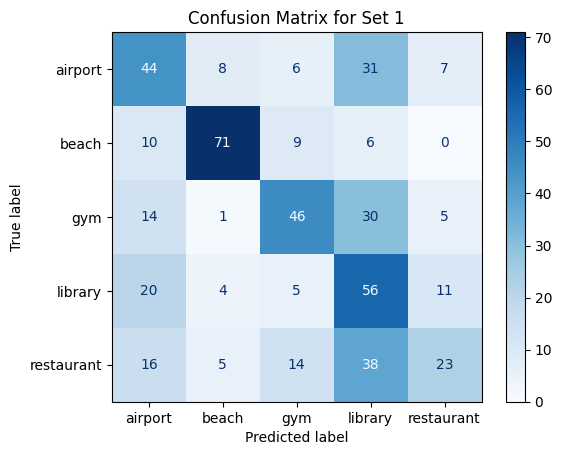

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Define hyperparameters for Set 1
params_set_1 = {
    'criterion': 'gini',
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt'
}
# Train and validate with Set 1
clf_set_1 = DecisionTreeClassifier(**params_set_1)
clf_set_1.fit(X_train, y_train_enc)
y_val_pred_set_1 = clf_set_1.predict(X_val)
print(f'Set 1 - Validation Accuracy: {accuracy_score(y_val_enc, y_val_pred_set_1)}')
print(f'Set 1 - Validation Classification Report:\n{classification_report(y_val_enc, y_val_pred_set_1, target_names=le.classes_)}')
# Display confusion matrix for Set 1
cm_set_1 = confusion_matrix(y_val_enc, y_val_pred_set_1)
disp_set_1 = ConfusionMatrixDisplay(confusion_matrix=cm_set_1, display_labels=le.classes_)
disp_set_1.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Set 1')
plt.show()

Set 2 - Validation Accuracy: 0.49375
Set 2 - Validation Classification Report:
              precision    recall  f1-score   support

     airport       0.43      0.40      0.41        96
       beach       0.73      0.77      0.75        96
         gym       0.50      0.55      0.52        96
     library       0.38      0.36      0.37        96
  restaurant       0.40      0.39      0.39        96

    accuracy                           0.49       480
   macro avg       0.49      0.49      0.49       480
weighted avg       0.49      0.49      0.49       480



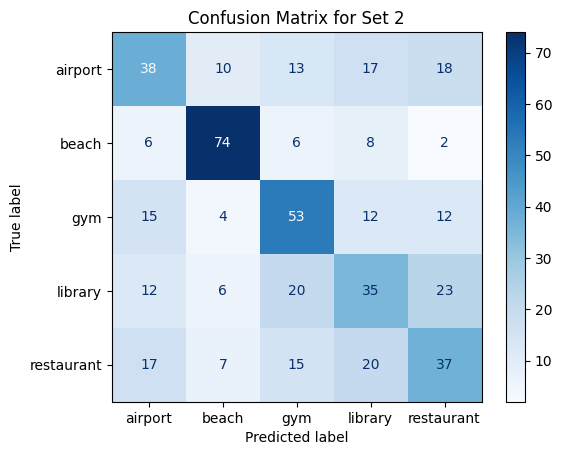

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Define hyperparameters for Set 2
params_set_1 = {
    'criterion': 'entropy',
    'max_depth': 20,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'max_features': 'sqrt'
}
# Train and validate with Set 2
clf_set_1 = DecisionTreeClassifier(**params_set_1)
clf_set_1.fit(X_train, y_train_enc)
y_val_pred_set_1 = clf_set_1.predict(X_val)
print(f'Set 2 - Validation Accuracy: {accuracy_score(y_val_enc, y_val_pred_set_1)}')
print(f'Set 2 - Validation Classification Report:\n{classification_report(y_val_enc, y_val_pred_set_1, target_names=le.classes_)}')
# Display confusion matrix for Set 2
cm_set_1 = confusion_matrix(y_val_enc, y_val_pred_set_1)
disp_set_1 = ConfusionMatrixDisplay(confusion_matrix=cm_set_1, display_labels=le.classes_)
disp_set_1.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Set 2')
plt.show()

##Semi-supervised learning Classification with Decision Trees

No more unlabeled samples remaining. Stopping early.

Test Performance Metrics
Test Accuracy: 0.4
Test Precision: 0.41119845823278667
Test Recall: 0.4
Test F1 Score: 0.40117926799279485
Test Classification Report:
              precision    recall  f1-score   support

     airport       0.37      0.32      0.34       120
       beach       0.67      0.57      0.62       120
         gym       0.41      0.49      0.45       120
     library       0.34      0.25      0.29       120
  restaurant       0.28      0.37      0.32       120

    accuracy                           0.40       600
   macro avg       0.41      0.40      0.40       600
weighted avg       0.41      0.40      0.40       600



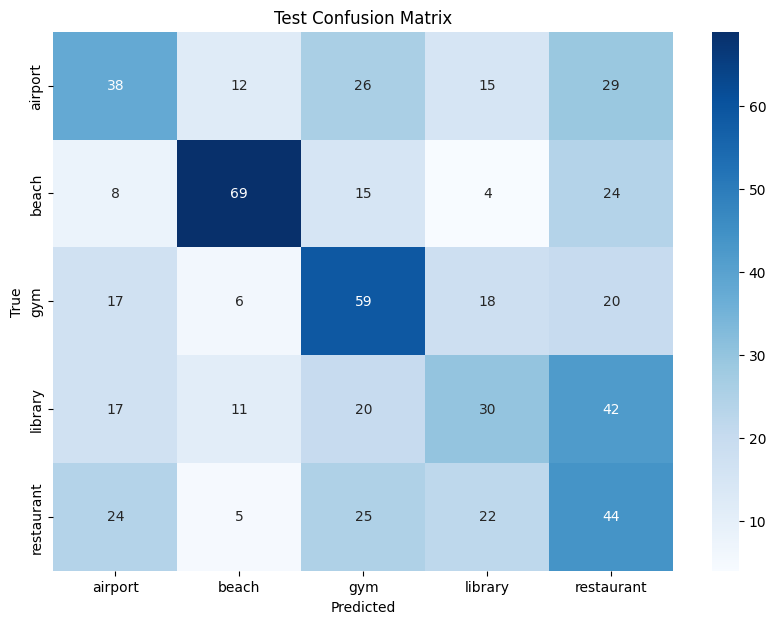

In [11]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Split the training data into labelled (20%) and unlabeled (80%)
X_train_labeled, X_train_unlabeled, y_train_labeled, y_train_unlabeled = train_test_split(X_train_flat, y_train_enc, test_size=0.8, stratify=y_train_enc, random_state=42)

# Function to perform semi-supervised learning
def semi_supervised_learning(X_labeled, y_labeled, X_unlabeled, iterations=5, confidence_threshold=0.85):
    clf = DecisionTreeClassifier()
    for iteration in range(iterations):
        clf.fit(X_labeled, y_labeled)
        y_unlabeled_pred = clf.predict_proba(X_unlabeled)
        high_confidence_idx = np.where((np.max(y_unlabeled_pred, axis=1) >= confidence_threshold))[0]

        # Check if there are high-confidence samples
        if len(high_confidence_idx) == 0:
            print(f"No high-confidence samples found in iteration {iteration}. Stopping early.")
            break

        X_high_conf = X_unlabeled[high_confidence_idx]
        y_high_conf = np.argmax(y_unlabeled_pred[high_confidence_idx], axis=1)

        X_labeled = np.vstack((X_labeled, X_high_conf))
        y_labeled = np.hstack((y_labeled, y_high_conf))

        # Remove high-confidence samples from the unlabeled set
        X_unlabeled = np.delete(X_unlabeled, high_confidence_idx, axis=0)

        # If no more unlabeled samples, break
        if X_unlabeled.shape[0] == 0:
            print("No more unlabeled samples remaining. Stopping early.")
            break

    return clf

# Perform semi-supervised learning
clf_semi_supervised = semi_supervised_learning(X_train_labeled, y_train_labeled, X_train_unlabeled)

# Evaluate the classifier on the test set
y_test_pred = clf_semi_supervised.predict(X_test_flat)
test_accuracy = accuracy_score(y_test_enc, y_test_pred)
test_precision = precision_score(y_test_enc, y_test_pred, average='weighted')
test_recall = recall_score(y_test_enc, y_test_pred, average='weighted')
test_f1 = f1_score(y_test_enc, y_test_pred, average='weighted')
test_conf_matrix = confusion_matrix(y_test_enc, y_test_pred)

print("\nTest Performance Metrics")
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test F1 Score: {test_f1}')
print(f'Test Classification Report:\n{classification_report(y_test_enc, y_test_pred, target_names=le.classes_)}')

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()


With Supervised Learning with decision tree( different hyper parameters)


Test Performance Metrics
Test Accuracy: 0.3616666666666667
Test Precision: 0.36518881168687384
Test Recall: 0.3616666666666667
Test F1 Score: 0.3626886473345871
Test Classification Report:
              precision    recall  f1-score   support

     airport       0.26      0.26      0.26       120
       beach       0.65      0.60      0.62       120
         gym       0.34      0.39      0.36       120
     library       0.27      0.24      0.25       120
  restaurant       0.32      0.32      0.32       120

    accuracy                           0.36       600
   macro avg       0.37      0.36      0.36       600
weighted avg       0.37      0.36      0.36       600



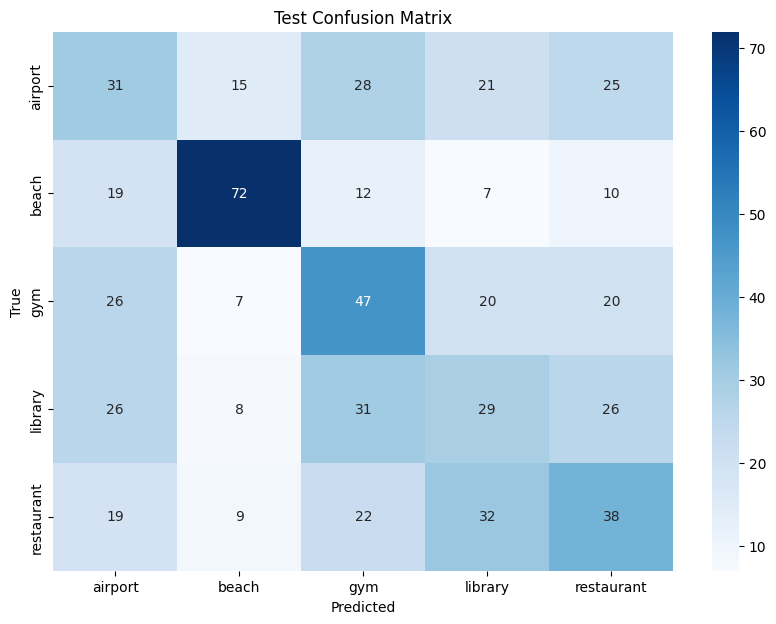

In [12]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Split the training data into labelled (20%) and unlabeled (80%)
X_train_labeled, X_train_unlabeled, y_train_labeled, y_train_unlabeled = train_test_split(X_train_flat, y_train_enc, test_size=0.8, stratify=y_train_enc, random_state=42)

# Function to perform semi-supervised learning
def semi_supervised_learning(X_labeled, y_labeled, X_unlabeled, iterations=5, confidence_threshold=0.85):
    clf = DecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', criterion='entropy')

    for iteration in range(iterations):
        clf.fit(X_labeled, y_labeled)
        y_unlabeled_pred = clf.predict_proba(X_unlabeled)
        high_confidence_idx = np.where((np.max(y_unlabeled_pred, axis=1) >= confidence_threshold))[0]

        # Check if there are high-confidence samples
        if len(high_confidence_idx) == 0:
            print(f"No high-confidence samples found in iteration {iteration}. Stopping early.")
            break

        X_high_conf = X_unlabeled[high_confidence_idx]
        y_high_conf = np.argmax(y_unlabeled_pred[high_confidence_idx], axis=1)

        X_labeled = np.vstack((X_labeled, X_high_conf))
        y_labeled = np.hstack((y_labeled, y_high_conf))

        # Remove high-confidence samples from the unlabeled set
        X_unlabeled = np.delete(X_unlabeled, high_confidence_idx, axis=0)

        # If no more unlabeled samples, break
        if X_unlabeled.shape[0] == 0:
            print("No more unlabeled samples remaining. Stopping early.")
            break

    return clf

# Perform semi-supervised learning
clf_semi_supervised = semi_supervised_learning(X_train_labeled, y_train_labeled, X_train_unlabeled)

# Evaluate the classifier on the test set
y_test_pred = clf_semi_supervised.predict(X_test_flat)
test_accuracy = accuracy_score(y_test_enc, y_test_pred)
test_precision = precision_score(y_test_enc, y_test_pred, average='weighted')
test_recall = recall_score(y_test_enc, y_test_pred, average='weighted')
test_f1 = f1_score(y_test_enc, y_test_pred, average='weighted')
test_conf_matrix = confusion_matrix(y_test_enc, y_test_pred)

print("\nTest Performance Metrics")
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test F1 Score: {test_f1}')
print(f'Test Classification Report:\n{classification_report(y_test_enc, y_test_pred, target_names=le.classes_)}')

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()


Test Performance Metrics
Test Accuracy: 0.3933333333333333
Test Precision: 0.3848365014588318
Test Recall: 0.3933333333333333
Test F1 Score: 0.3764151791188166
Test Classification Report:
              precision    recall  f1-score   support

     airport       0.28      0.31      0.29       120
       beach       0.59      0.68      0.63       120
         gym       0.35      0.54      0.42       120
     library       0.31      0.14      0.19       120
  restaurant       0.39      0.29      0.33       120

    accuracy                           0.39       600
   macro avg       0.38      0.39      0.38       600
weighted avg       0.38      0.39      0.38       600



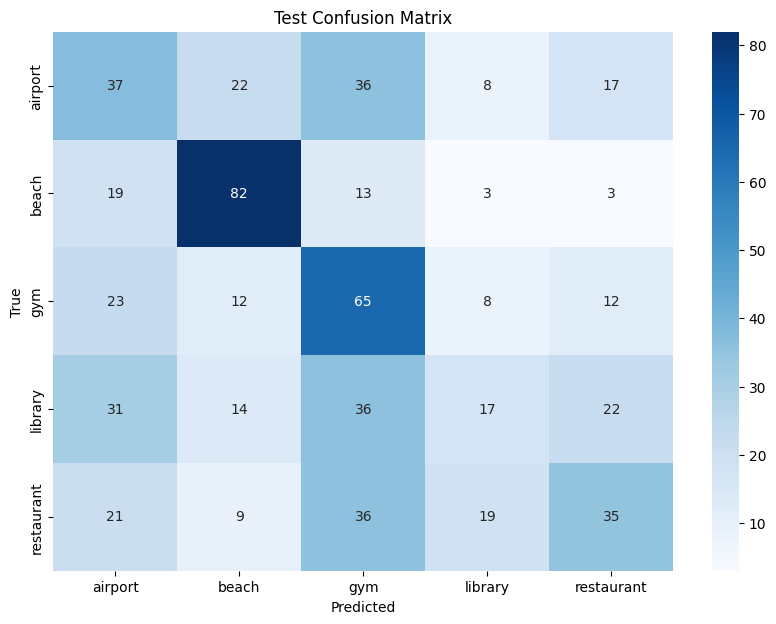

In [13]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assume X_train_flat, y_train_enc, X_test_flat, y_test_enc, and le are already defined

# Split the training data into labelled (20%) and unlabeled (80%)
X_train_labeled, X_train_unlabeled, y_train_labeled, y_train_unlabeled = train_test_split(X_train_flat, y_train_enc, test_size=0.8, stratify=y_train_enc, random_state=42)

# Function to perform semi-supervised learning
def semi_supervised_learning(X_labeled, y_labeled, X_unlabeled, iterations=5, confidence_threshold=0.85):
    clf = DecisionTreeClassifier(max_depth=15, min_samples_split=10, min_samples_leaf=4, max_features='log2', criterion='gini')

    for iteration in range(iterations):
        clf.fit(X_labeled, y_labeled)
        y_unlabeled_pred = clf.predict_proba(X_unlabeled)
        high_confidence_idx = np.where((np.max(y_unlabeled_pred, axis=1) >= confidence_threshold))[0]

        # Check if there are high-confidence samples
        if len(high_confidence_idx) == 0:
            print(f"No high-confidence samples found in iteration {iteration}. Stopping early.")
            break

        X_high_conf = X_unlabeled[high_confidence_idx]
        y_high_conf = np.argmax(y_unlabeled_pred[high_confidence_idx], axis=1)

        X_labeled = np.vstack((X_labeled, X_high_conf))
        y_labeled = np.hstack((y_labeled, y_high_conf))

        # Remove high-confidence samples from the unlabeled set
        X_unlabeled = np.delete(X_unlabeled, high_confidence_idx, axis=0)

        # If no more unlabeled samples, break
        if X_unlabeled.shape[0] == 0:
            print("No more unlabeled samples remaining. Stopping early.")
            break

    return clf

# Perform semi-supervised learning
clf_semi_supervised = semi_supervised_learning(X_train_labeled, y_train_labeled, X_train_unlabeled)

# Evaluate the classifier on the test set
y_test_pred = clf_semi_supervised.predict(X_test_flat)
test_accuracy = accuracy_score(y_test_enc, y_test_pred)
test_precision = precision_score(y_test_enc, y_test_pred, average='weighted')
test_recall = recall_score(y_test_enc, y_test_pred, average='weighted')
test_f1 = f1_score(y_test_enc, y_test_pred, average='weighted')
test_conf_matrix = confusion_matrix(y_test_enc, y_test_pred)

print("\nTest Performance Metrics")
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test F1 Score: {test_f1}')
print(f'Test Classification Report:\n{classification_report(y_test_enc, y_test_pred, target_names=le.classes_)}')

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Using Data Augmentation

In [14]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the image dimensions
IMG_HEIGHT = 64
IMG_WIDTH = 64

# Function to load images and extract features
def load_images_from_folder(folder, img_height, img_width):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                img_path = os.path.join(label_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (img_height, img_width))
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

# Paths to your datasets
train_dir = '/content/drive/MyDrive/dataset/train'
validation_dir = '/content/drive/MyDrive/dataset/validation'
test_dir = '/content/drive/MyDrive/dataset/test'

X_train, y_train = load_images_from_folder(train_folder, IMG_HEIGHT, IMG_WIDTH)
X_val, y_val = load_images_from_folder(val_folder, IMG_HEIGHT, IMG_WIDTH)
X_test, y_test = load_images_from_folder(test_folder, IMG_HEIGHT, IMG_WIDTH)


In [15]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Normalize images
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Apply data augmentation to the training set
augmented_images = []
augmented_labels = []

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=32, shuffle=False):
    augmented_images.extend(X_batch)
    augmented_labels.extend(y_batch)
    if len(augmented_images) >= 2 * len(X_train):  # Increase dataset size with augmentation
        break

X_train_augmented = np.array(augmented_images)
y_train_augmented = np.array(augmented_labels)


In [16]:
# Flatten images
X_train_flat = X_train_augmented.reshape((X_train_augmented.shape[0], -1))
X_val_flat = X_val.reshape((X_val.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_augmented)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)



Test Performance Metrics
Test Accuracy: 0.365
Test Precision: 0.3608832139333757
Test Recall: 0.365
Test F1 Score: 0.36023260511777855
Test Classification Report:
              precision    recall  f1-score   support

     airport       0.21      0.18      0.20       120
       beach       0.69      0.73      0.71       120
         gym       0.37      0.36      0.36       120
     library       0.25      0.33      0.28       120
  restaurant       0.29      0.22      0.25       120

    accuracy                           0.36       600
   macro avg       0.36      0.36      0.36       600
weighted avg       0.36      0.36      0.36       600



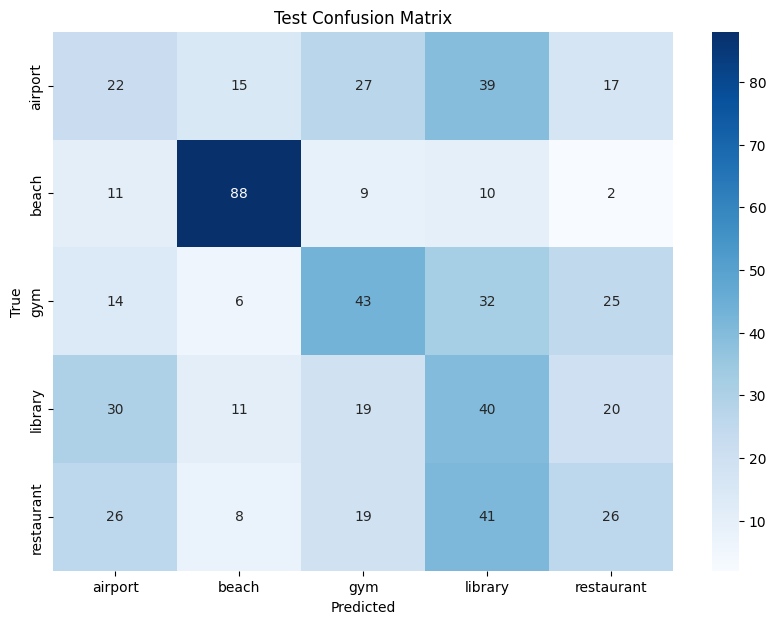

In [21]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Split the training data into labelled (20%) and unlabeled (80%)
X_train_labeled, X_train_unlabeled, y_train_labeled, y_train_unlabeled = train_test_split(X_train_flat, y_train_enc, test_size=0.8, stratify=y_train_enc, random_state=42)

# Function to perform semi-supervised learning
def semi_supervised_learning(X_labeled, y_labeled, X_unlabeled, iterations=5, confidence_threshold=0.85):
    clf = DecisionTreeClassifier(max_depth=20, min_samples_split=10, min_samples_leaf=4, max_features='log2', criterion='entropy')

    for iteration in range(iterations):
        clf.fit(X_labeled, y_labeled)
        y_unlabeled_pred = clf.predict_proba(X_unlabeled)
        high_confidence_idx = np.where((np.max(y_unlabeled_pred, axis=1) >= confidence_threshold))[0]

        # Check if there are high-confidence samples
        if len(high_confidence_idx) == 0:
            print(f"No high-confidence samples found in iteration {iteration}. Stopping early.")
            break

        X_high_conf = X_unlabeled[high_confidence_idx]
        y_high_conf = np.argmax(y_unlabeled_pred[high_confidence_idx], axis=1)

        X_labeled = np.vstack((X_labeled, X_high_conf))
        y_labeled = np.hstack((y_labeled, y_high_conf))

        # Remove high-confidence samples from the unlabeled set
        X_unlabeled = np.delete(X_unlabeled, high_confidence_idx, axis=0)

        # If no more unlabeled samples, break
        if X_unlabeled.shape[0] == 0:
            print("No more unlabeled samples remaining. Stopping early.")
            break

    return clf

# Perform semi-supervised learning
clf_semi_supervised = semi_supervised_learning(X_train_labeled, y_train_labeled, X_train_unlabeled)

# Evaluate the classifier on the test set
y_test_pred = clf_semi_supervised.predict(X_test_flat)
test_accuracy = accuracy_score(y_test_enc, y_test_pred)
test_precision = precision_score(y_test_enc, y_test_pred, average='weighted')
test_recall = recall_score(y_test_enc, y_test_pred, average='weighted')
test_f1 = f1_score(y_test_enc, y_test_pred, average='weighted')
test_conf_matrix = confusion_matrix(y_test_enc, y_test_pred)

print("\nTest Performance Metrics")
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test F1 Score: {test_f1}')
print(f'Test Classification Report:\n{classification_report(y_test_enc, y_test_pred, target_names=le.classes_)}')

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()
